In [1]:
# Imports
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import gc
from IPython.display import display

# Sci-kit Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# NN
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Conv2D, MaxPooling2D

In [2]:
# Load file
df = pd.read_csv("all_merged_sw.csv",
                 usecols=['post_id', 'date', 'sw_18_num_comments', 'sw_18_score', 'sw_18_total_awards',
                          'author_commentkarma', 'sw_18_compound_score', 'trustworthy', 'sw_18_author_trust',
                          'author_trust', 'author_id', 'author_name',
                          'ticker', 'post_type', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
                          'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X', 
                          'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
                          'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
                          'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
                          'adjclose_1_X', 'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                          'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y',
                          'adjclose_9_Y', 'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y',
                          'adjclose_13_Y', 'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                          'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y',
                          'adjclose_21_Y'])

# Apply trust filter
df = df[(df["author_trust"] >= 0.8) & (df["trustworthy"] == 1)]

df

,post_id,date,author_commentkarma,author_id,author_name,ticker,post_type,adjclose_20_X,adjclose_19_X,adjclose_18_X,...,adjclose_19_Y,adjclose_20_Y,adjclose_21_Y,trustworthy,author_trust,sw_18_num_comments,sw_18_score,sw_18_total_awards,sw_18_compound_score,sw_18_author_trust
3,ed0rg2j,2019-01-01,744.0,2dk1wq99,nightman_123,WSBC,comment,38.873425,39.189323,38.214558,...,37.799068,37.862701,36.917271,1,0.888889,9.400000,9.800000,0.000000,-0.082100,0.638215
92,ed2x6fn,2019-01-02,712.0,rw1ynq0,martimook,CPSI,comment,25.979984,25.950769,25.882610,...,25.366512,25.347040,25.551525,1,0.800000,2.000000,61.000000,0.000000,0.051600,0.800000
100,ed2ygwl,2019-01-02,788.0,8wfb2,Crispytender,ABCB,comment,41.132088,40.978432,41.199310,...,36.524799,36.476631,36.563339,1,0.857143,3.250000,11.375000,0.000000,0.428025,0.513544
101,ed2ygwl,2019-01-02,788.0,8wfb2,Crispytender,CFFN,comment,12.528222,12.340834,12.314064,...,11.983905,11.609129,11.559727,1,0.857143,2.357143,9.285714,0.000000,0.173250,0.510156
120,ed2ygwl,2019-01-02,788.0,8wfb2,Crispytender,FANG,comment,105.159828,106.703209,104.607254,...,95.423157,97.423836,98.243164,1,0.857143,3.250000,11.375000,0.000000,0.428025,0.513544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940494,ghkrh6s,2020-12-31,1283.0,ihqbc,keikun2002,WSBC,comment,28.073952,29.172199,29.535013,...,29.550983,28.738380,29.313148,1,1.000000,55.954741,35.823259,0.110401,0.052974,0.436027
940516,ghmxpxm,2020-12-31,1283.0,ihqbc,keikun2002,WSBC,comment,28.073952,29.172199,29.535013,...,29.550983,28.738380,29.313148,1,1.000000,55.954741,35.823259,0.110401,0.052974,0.436027
940679,ghldnvu,2020-12-31,69.0,6mewt3dg,narconocs,EDIT,comment,30.590000,31.340000,29.450001,...,61.130001,61.349998,62.889999,1,1.000000,4.350365,21.945255,0.217153,0.185101,0.420735
940681,ghldnvu,2020-12-31,69.0,6mewt3dg,narconocs,AUB,comment,29.704462,31.154430,31.670855,...,33.359173,32.614326,33.369102,1,1.000000,1.345638,16.694631,0.016779,0.216898,0.429549


In [3]:
# Print the colum names
df.columns.values

array(['post_id', 'date', 'author_commentkarma', 'author_id',
       'author_name', 'ticker', 'post_type', 'adjclose_20_X',
       'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
       'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
       'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
       'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
       'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X', 'adjclose_2_Y',
       'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y', 'adjclose_6_Y',
       'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
       'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y', 'adjclose_14_Y',
       'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y', 'adjclose_18_Y',
       'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y', 'trustworthy',
       'author_trust', 'sw_18_num_comments', 'sw_18_score',
       'sw_18_total_awards', 'sw_18_compound_score', 'sw_18_author_trust'],
      dty

In [4]:
# Find the min and max at 1-4 business week intervals
df['5day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmin(axis=1)

df['10day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmin(axis=1)

df['15day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmin(axis=1)

df['20day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmin(axis=1)

df['5day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmax(axis=1)

df['10day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmax(axis=1)

df['15day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmax(axis=1)

df['20day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmax(axis=1)

# Extract the day number and convert to int
df['5day_min'] = df['5day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_min'] = df['10day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_min'] = df['15day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_min'] = df['20day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['5day_max'] = df['5day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_max'] = df['10day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_max'] = df['15day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_max'] = df['20day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)

In [5]:
# Get the X-variable columns
df_X = df[['sw_18_num_comments', 'sw_18_score', 'sw_18_total_awards', 'author_commentkarma',
           'sw_18_compound_score', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
           'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X',
           'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
           'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
           'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
           'adjclose_1_X']].to_numpy()

# Get the Y-variable columns
df_Y = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y',
           'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y',
           'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
           'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y',
           'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y',
           '5day_min', '10day_min', '15day_min', '20day_min', '5day_max',
           '10day_max', '15day_max', '20day_max']].to_numpy()

# Clear up memory
del df
gc.collect()

# Get 80% of the data by date
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2,
                                                    shuffle=False)

# Print
print(X_train)
print(X_test)
print(y_train)
print(y_test)

[[9.40000000e+00 9.80000000e+00 0.00000000e+00 ... 3.72127113e+01
  3.70953789e+01 3.65989647e+01]
 [2.00000000e+00 6.10000000e+01 0.00000000e+00 ... 2.72181587e+01
  2.61317596e+01 2.60929604e+01]
 [3.25000000e+00 1.13750000e+01 0.00000000e+00 ... 4.19195824e+01
  4.16122704e+01 4.19579926e+01]
 ...
 [3.04819277e+00 1.63915663e+01 6.47590361e-02 ... 1.22900000e+01
  1.17700005e+01 1.19300003e+01]
 [6.00000000e-01 6.00000000e+00 0.00000000e+00 ... 3.00300007e+01
  3.07900009e+01 3.08600006e+01]
 [2.28846154e+00 9.62500000e+00 2.24358974e-02 ... 2.44000006e+00
  2.48000002e+00 2.55999994e+00]]
[[5.34893617e+00 6.89425532e+01 1.19148936e-01 ... 1.72500000e+01
  1.55799999e+01 1.42500000e+01]
 [6.56081734e+01 2.27741321e+01 5.66866852e-02 ... 2.01116562e+01
  1.97684536e+01 1.92193298e+01]
 [6.56081734e+01 2.27741321e+01 5.66866852e-02 ... 2.01116562e+01
  1.97684536e+01 1.92193298e+01]
 ...
 [4.35036496e+00 2.19452555e+01 2.17153285e-01 ... 3.04500008e+01
  2.83099995e+01 3.12999992e+01]

In [6]:
# Normalize data
scaler = MinMaxScaler()

print(scaler.fit(X_train))
xtrain_scale=scaler.transform(X_train)

print(scaler.fit(X_test))
xval_scale=scaler.transform(X_test)

print(scaler.fit(y_train))
ytrain_scale=scaler.transform(y_train)

print(scaler.fit(y_test))
yval_scale=scaler.transform(y_test)

# Set input and output dimensions
indim = X_train.shape[1]
outdim = y_train.shape[1]

# Initialize Feed-Forward Neural Network
model = Sequential()

# Create NN structure
# Input layer
model.add(Dense(indim+1, input_dim=indim, activation="softmax"))

# Hidden layer with ~sqrt(X_train.shape[0] = sqrt(188157))
model.add(Dense(434, activation="softmax"))

# Output layer
model.add(Dense(outdim))

# Compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mse', 'mae'])

# Train
model.fit(xtrain_scale, ytrain_scale, epochs=10, batch_size=20, verbose=0)

# Predict
ypred = model.predict(xval_scale)

# Scale back to original scale
ypred = scaler.inverse_transform(ypred)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [7]:
# Evaluate RMSE
rmse = mean_squared_error(y_test, ypred, multioutput='raw_values', squared=False)

# For each value in rmse
for i in range(1, len(rmse)+1):

    # Print the RMSE values for adjClose
    if i < 21:
        print("The RMSE for adjClose_{}_Y = ".format(i+1), rmse[i-1])

    # Print the RMSE values for min day
    elif 21 <= i < 25:
        print("The RMSE for {}day_min = ".format((i-20)*5), rmse[i-1])

    # Print the RMSE for max day
    else:
        print("The RMSE for {}day_max = ".format((i-24)*5), rmse[i-1])

The RMSE for adjClose_2_Y =  43.27103648575321
The RMSE for adjClose_3_Y =  43.86816791862566
The RMSE for adjClose_4_Y =  45.04955358288309
The RMSE for adjClose_5_Y =  40.921708470063045
The RMSE for adjClose_6_Y =  45.82140339838472
The RMSE for adjClose_7_Y =  49.017934223828384
The RMSE for adjClose_8_Y =  48.35627182750071
The RMSE for adjClose_9_Y =  48.554081830063936
The RMSE for adjClose_10_Y =  48.405065336594134
The RMSE for adjClose_11_Y =  52.16403633783629
The RMSE for adjClose_12_Y =  54.16392486736336
The RMSE for adjClose_13_Y =  55.59435618489338
The RMSE for adjClose_14_Y =  56.1912284097443
The RMSE for adjClose_15_Y =  57.655169787243935
The RMSE for adjClose_16_Y =  53.8315532548335
The RMSE for adjClose_17_Y =  53.152394262526194
The RMSE for adjClose_18_Y =  55.325446048583984
The RMSE for adjClose_19_Y =  56.347050530614396
The RMSE for adjClose_20_Y =  56.269735945043834
The RMSE for adjClose_21_Y =  57.116750918205334
The RMSE for 5day_min =  1.5852915403078

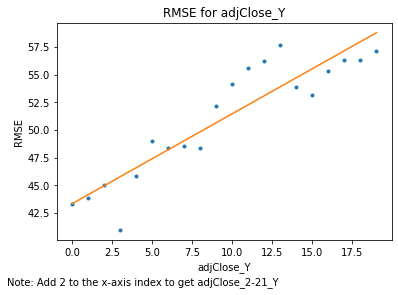

In [8]:
# Plot the RMSE for adjClose
x = np.arange(20)
y = rmse[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('RMSE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('RMSE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()

In [9]:
# Evaluate MAE
mae = mean_absolute_error(y_test, ypred, multioutput='raw_values')

# For each value in mae
for i in range(1, len(mae)+1):

    # Print the MAE values for adjClose
    if i < 21:
        print("The MAE for adjClose_{}_Y = ".format(i+1), mae[i-1])

    # Print the MAE values for min day
    elif 21 <= i < 25:
        print("The MAE for {}day_min = ".format((i-20)*5), mae[i-1])

    # Print the MAE for max day
    else:
        print("The MAE for {}day_max = ".format((i-24)*5), mae[i-1])

The MAE for adjClose_2_Y =  19.08872736922423
The MAE for adjClose_3_Y =  19.165555782990907
The MAE for adjClose_4_Y =  20.62735698411232
The MAE for adjClose_5_Y =  20.54101637379624
The MAE for adjClose_6_Y =  21.688116322023546
The MAE for adjClose_7_Y =  22.83108954590594
The MAE for adjClose_8_Y =  21.798359828928312
The MAE for adjClose_9_Y =  22.055100154042034
The MAE for adjClose_10_Y =  21.745909139840048
The MAE for adjClose_11_Y =  22.7854778562953
The MAE for adjClose_12_Y =  22.940820088322738
The MAE for adjClose_13_Y =  23.296083249135414
The MAE for adjClose_14_Y =  24.15601824035796
The MAE for adjClose_15_Y =  24.65093995492494
The MAE for adjClose_16_Y =  24.009855574038657
The MAE for adjClose_17_Y =  24.607782911097843
The MAE for adjClose_18_Y =  25.432532754282178
The MAE for adjClose_19_Y =  25.630666274314635
The MAE for adjClose_20_Y =  25.497947847752737
The MAE for adjClose_21_Y =  24.98164157150135
The MAE for 5day_min =  1.4092396569095589
The MAE for 10

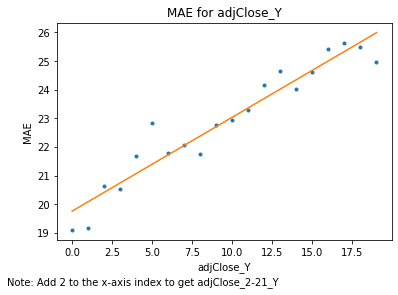

In [10]:
# Plot the MAE for adjClose
x = np.arange(20)
y = mae[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('MAE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('MAE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()